## Reward-effort task simulations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

### Simulate participants

In [3]:
# Trial numbers (40 mins, 6s per trial, 400 total trials)
num_trials = 400
num_blocks = 8 # 2 action type x 2 global effort state x 2 attentional focus
num_trials_per_block = num_blocks / num_blocks

# Reward and effort levels
outcome_levels_n = np.linspace(-10, 10, 11) 
outcome_levels = outcome_levels_n[outcome_levels_n != 0] # remove 0
effort_levels = np.linspace(5, 10, 11) 


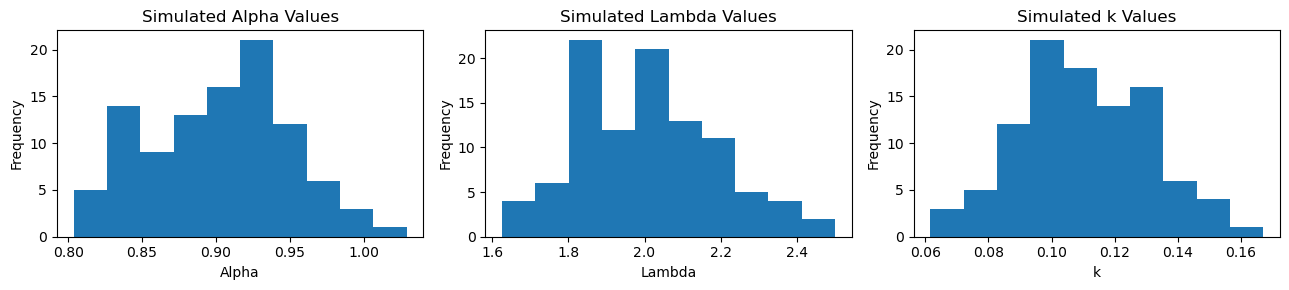

In [4]:
# Simulate participants with different sensitivities - get realistic values from the literature
num_participants = 100

# Specify mean and sd of parameters
alpha_mean, alpha_std = 0.9, 0.05
lambda_mean, lambda_std = 2.0, 0.2
k_mean, k_std = 0.11, 0.02

# Generate parameters from normal distributions
alpha_values = np.random.normal(alpha_mean, alpha_std, num_participants)
lambda_values = np.random.normal(lambda_mean, lambda_std, num_participants)
k_values = np.random.normal(k_mean, k_std, num_participants)

# Ensure parameters are within a reasonable range
alpha_values = np.clip(alpha_values, 0.7, 1.2)
lambda_values = np.clip(lambda_values, 1.5, 2.5)
k_values = np.clip(k_values, 0, 1)


# Plot histograms of the parameters
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 3))

axes[0].hist(alpha_values)
axes[0].set_title('Simulated Alpha Values')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Frequency')

axes[1].hist(lambda_values)
axes[1].set_title('Simulated Lambda Values')
axes[1].set_xlabel('Lambda')
axes[1].set_ylabel('Frequency')

axes[2].hist(k_values)
axes[2].set_title('Simulated k Values')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

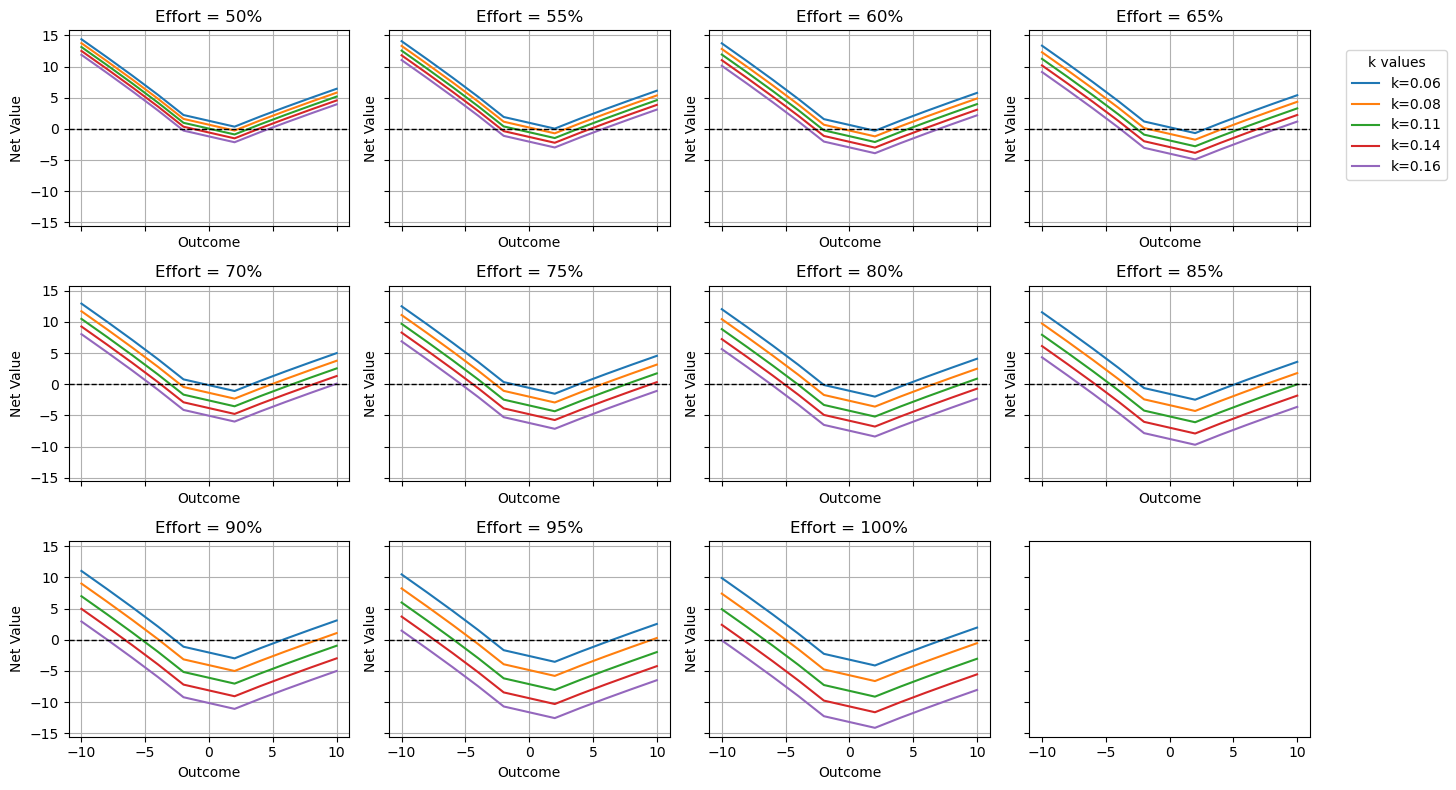

In [5]:
# Function to calculate net value based on outcome, effort, reward sensitivity alpha, loss sensitivty beta, effort sensitivity k, and loss aversion lambda
def calculate_net_value(outcome, effort, alpha, k, lambda_):
    if outcome >= 0:
        return (outcome ** alpha) - k * (effort ** 2)  # positive outcome - effort --> the higher the better
    else:
        return abs(-lambda_ * ((-outcome) ** alpha)) - k * (effort ** 2)  # removing the negative sign from the outcome to get magnitude of (negative) outcome - magnitude of effort --> the higher the less bad (ie better)



# Plot the net value function for different ks at different effort levels, fixing alpha and lambda at their mean values
plot_ks = np.linspace(0.06, 0.16, 5)  # different values for k
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.flatten()
for i, plot_effort in enumerate(effort_levels):
    ax = axes[i]
    for plot_k in plot_ks:
        net_values = [calculate_net_value(outcome, plot_effort, alpha_mean, plot_k, lambda_mean) for outcome in outcome_levels]
        ax.plot(outcome_levels, net_values, label=f'k={plot_k:.2f}')
    ax.set_title(f'Effort = {(plot_effort*10).astype(int)}%')
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Net Value')
    ax.axhline(0, color='black', lw=1, linestyle='--')
    ax.grid(True)
    if i == 0: 
        fig.legend(loc='center left', bbox_to_anchor=(0.96, 0.85), title="k values")
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

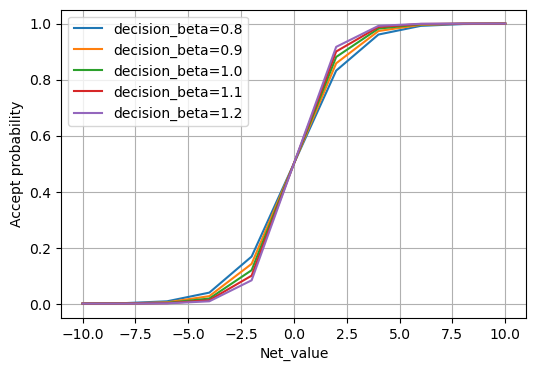

In [6]:
# Logistic function to get choice probabilities
decision_beta = 1  
def logistic_choice_prob(net_value, decision_beta):
    return 1 / (1 + np.exp(-decision_beta * net_value))


# Plot the Logistic function for different betas
plot_betas = np.linspace(0.8, 1.2, 5)
plt.figure(figsize=(6, 4))
for b in plot_betas:
    plt.plot(outcome_levels_n, logistic_choice_prob(outcome_levels_n, b), label=f'decision_beta={b:.1f}')
plt.xlabel('Net_value')
plt.ylabel('Accept probability')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Generate stimuli and responses
stimuli = []
responses = []

for outcome in outcome_levels:
    for effort in effort_levels:
        # Calculate net values for all participants
        net_values = np.array([calculate_net_value(outcome, effort, alpha, k, lambda_)
                               for alpha, k, lambda_ in zip(alpha_values, k_values, lambda_values)])
        
        # Apply logistic function to calculate acceptance probabilities
        probabilities = logistic_choice_prob(net_values, decision_beta)
        
        # Simulate binary choices (accept/reject) based on probabilities
        choices = np.random.binomial(1, probabilities)
        
        # Store stimuli and responses
        stimuli.append((outcome, effort))
        responses.append(choices)

# Convert responses to numpy array
responses = np.array(responses)



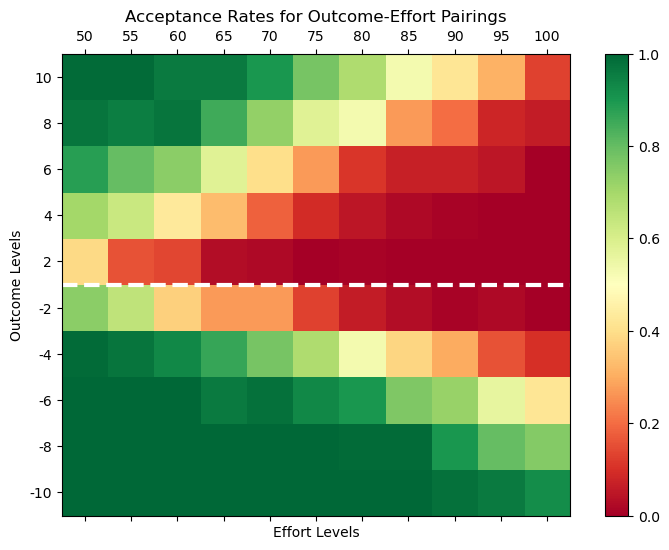

In [8]:
# Visualizing the acceptance rates for each reward-effort pairing across all participants
# Matrix looks asymmetric because of loss aversion
acceptance_rates = responses.mean(axis=1)

# Reshape acceptance rates for plotting 
# acceptance_rates is a 1D array representing the mean acceptance rates across all participants for each reward-effort pairing
# reshaped acceptance_matrix is a 2D array where rows represent different outcome levels and columns represent different effort levels
acceptance_matrix = acceptance_rates.reshape(len(outcome_levels), len(effort_levels))

fig, ax = plt.subplots(figsize=(9, 6))
cax = ax.matshow(acceptance_matrix, interpolation='nearest', cmap='RdYlGn')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(effort_levels)))
ax.set_yticks(np.arange(len(outcome_levels)))
ax.set_xticklabels((effort_levels*10).astype(int))
ax.set_yticklabels(outcome_levels.astype(int))
ax.invert_yaxis()
lowest_reward_index = np.where(outcome_levels == 2)[0][0]
ax.axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=3)

plt.xlabel('Effort Levels')
plt.ylabel('Outcome Levels')
plt.title('Acceptance Rates for Outcome-Effort Pairings')
plt.show()


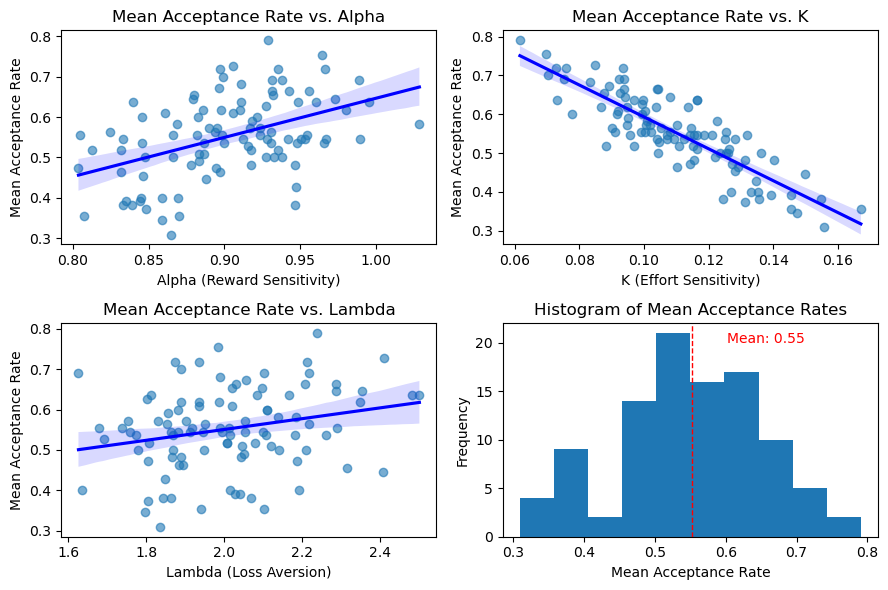

In [9]:
# Calculate mean acceptance rates
mean_acceptance_rates = responses.mean(axis=0)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# Plot for Alpha vs. Mean Acceptance Rate
sns.regplot(x=alpha_values, y=mean_acceptance_rates, ax=axs[0, 0], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[0, 0].set_xlabel('Alpha (Reward Sensitivity)')
axs[0, 0].set_ylabel('Mean Acceptance Rate')
axs[0, 0].set_title('Mean Acceptance Rate vs. Alpha')

# Plot for K vs. Mean Acceptance Rate
sns.regplot(x=k_values, y=mean_acceptance_rates, ax=axs[0, 1], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[0, 1].set_xlabel('K (Effort Sensitivity)')
axs[0, 1].set_ylabel('Mean Acceptance Rate')
axs[0, 1].set_title('Mean Acceptance Rate vs. K')

# Plot for Lambda vs. Mean Acceptance Rate
sns.regplot(x=lambda_values, y=mean_acceptance_rates, ax=axs[1, 0], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[1, 0].set_xlabel('Lambda (Loss Aversion)')
axs[1, 0].set_ylabel('Mean Acceptance Rate')
axs[1, 0].set_title('Mean Acceptance Rate vs. Lambda')

# Plot histogram of mean acceptance rates
axs[1, 1].hist(mean_acceptance_rates)
axs[1, 1].set_xlabel('Mean Acceptance Rate')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Histogram of Mean Acceptance Rates')
mean = np.mean(mean_acceptance_rates)
axs[1, 1].axvline(mean, color='red', lw=1, linestyle='--')
axs[1, 1].text(mean + 0.05, max(np.histogram(mean_acceptance_rates)[0]) * 0.95, f'Mean: {mean:.2f}', color='red')

plt.tight_layout()
plt.show()

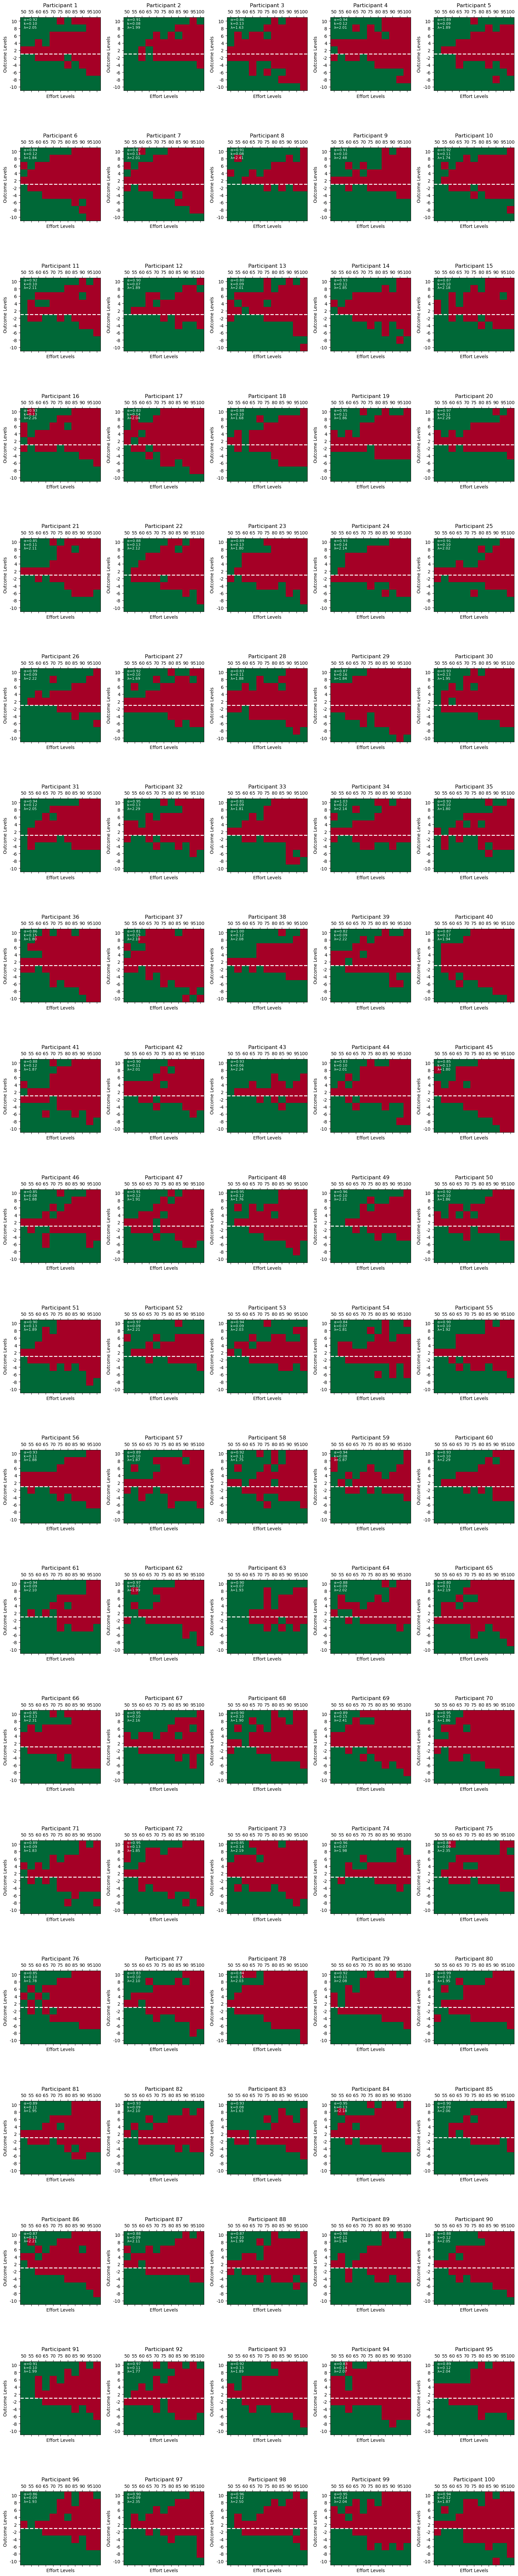

In [10]:
# Visualizing the acceptance rates for each participant separately
num_cols = 5 
num_rows = num_participants // num_cols + (1 if num_participants % num_cols else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))

for participant_idx in range(num_participants):
    row = participant_idx // num_cols
    col = participant_idx % num_cols
    
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    participant_responses = responses[:, participant_idx]
    participant_acceptance_matrix = participant_responses.reshape(len(outcome_levels), len(effort_levels))
    
    cax = ax.matshow(participant_acceptance_matrix, interpolation='nearest', cmap='RdYlGn')
    
    ax.set_xticks(np.arange(len(effort_levels)))
    ax.set_yticks(np.arange(len(outcome_levels)))
    ax.set_xticklabels((effort_levels*10).astype(int))
    ax.set_yticklabels(outcome_levels.astype(int))
    ax.invert_yaxis()
    lowest_reward_index = np.where(outcome_levels == 2)[0][0]
    ax.axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Effort Levels')
    ax.set_ylabel('Outcome Levels')
    ax.set_title(f'Participant {participant_idx + 1}')

    # Print participant parameters 
    params_text = (f"α={alpha_values[participant_idx]:.2f} \n"
                   f"k={k_values[participant_idx]:.2f} \n"
                   f"λ={lambda_values[participant_idx]:.2f}")
    ax.text(0, len(outcome_levels) - 2, params_text, color='white', fontsize=8)

plt.tight_layout()
plt.show()

### Generate trial schedules

 


------------------------------------------------ Schedule 1 --------------------------------------------------


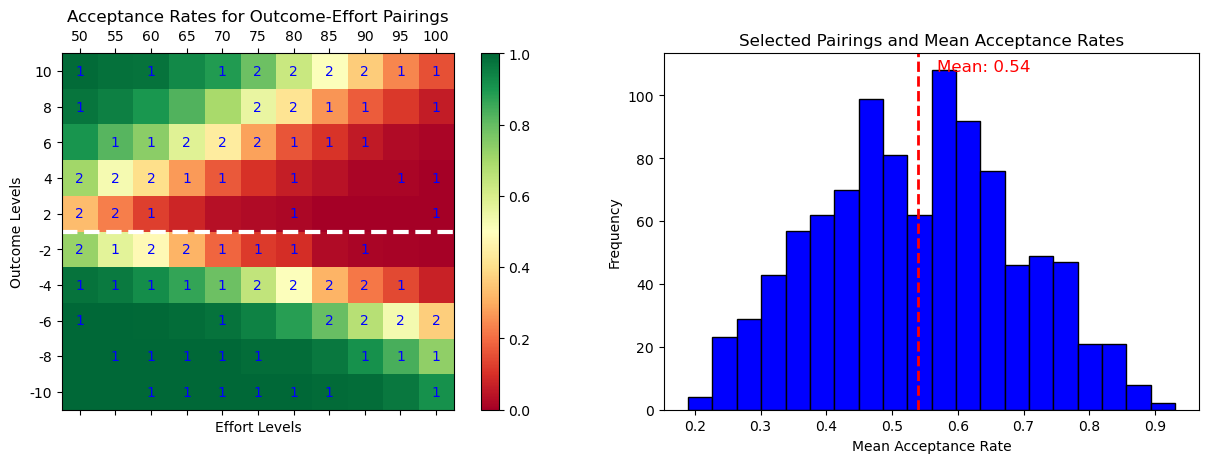

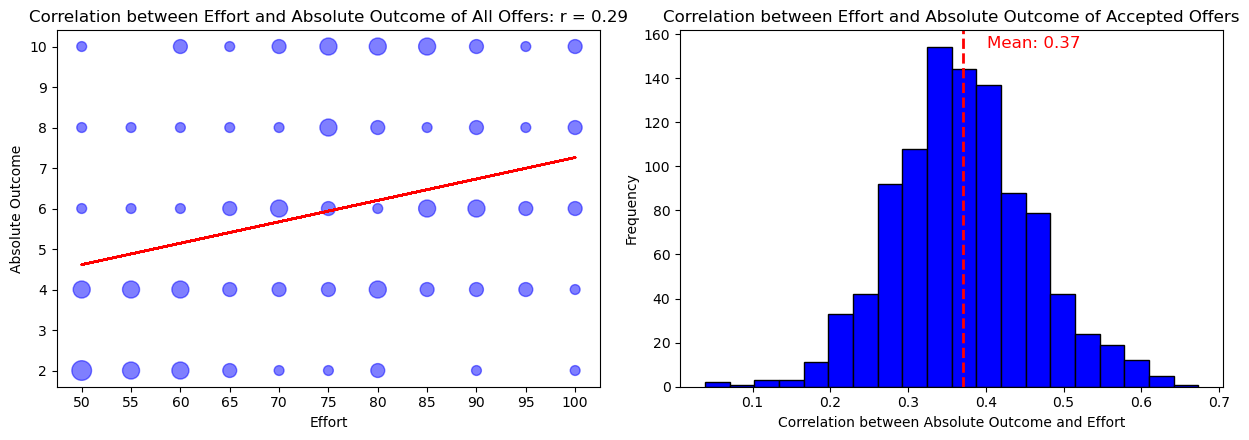

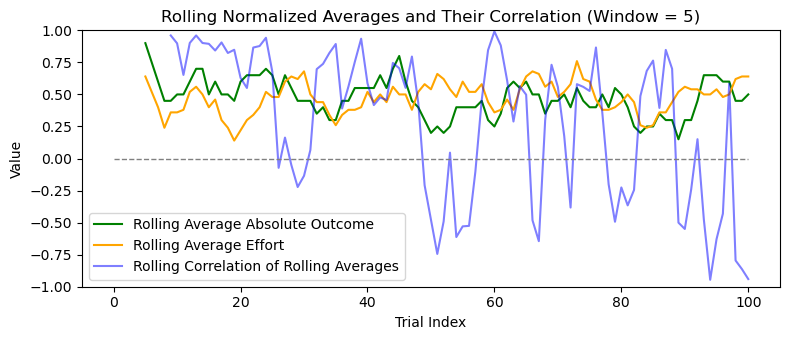

Schedule 1: Overall Correlation of Rolling Averages = 0.13
 


------------------------------------------------ Schedule 2 --------------------------------------------------


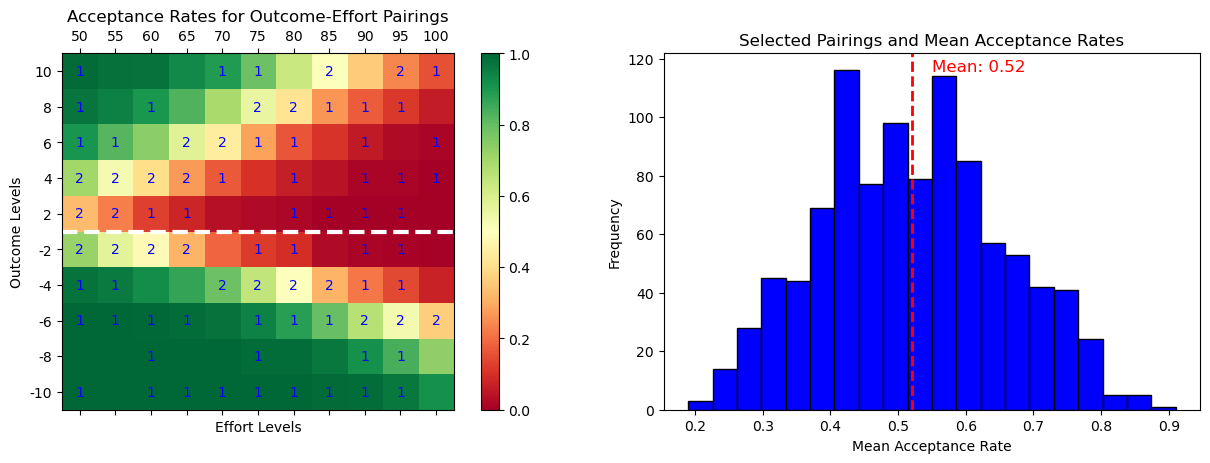

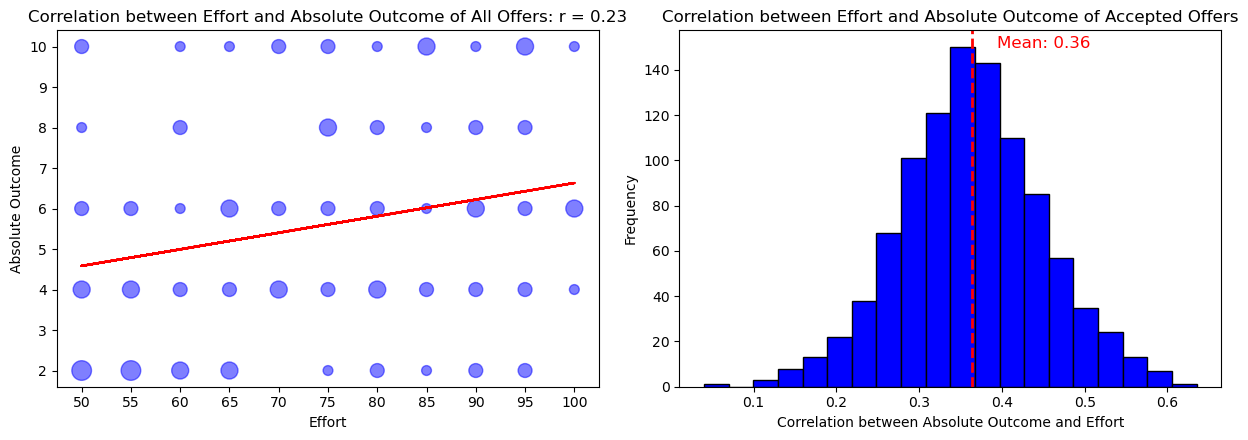

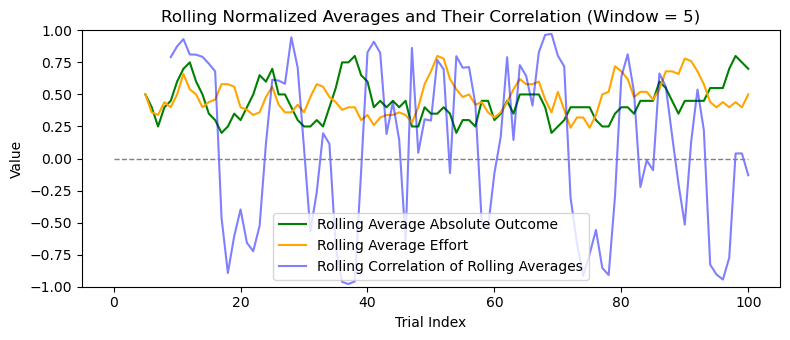

Schedule 2: Overall Correlation of Rolling Averages = -0.03
 


------------------------------------------------ Schedule 3 --------------------------------------------------


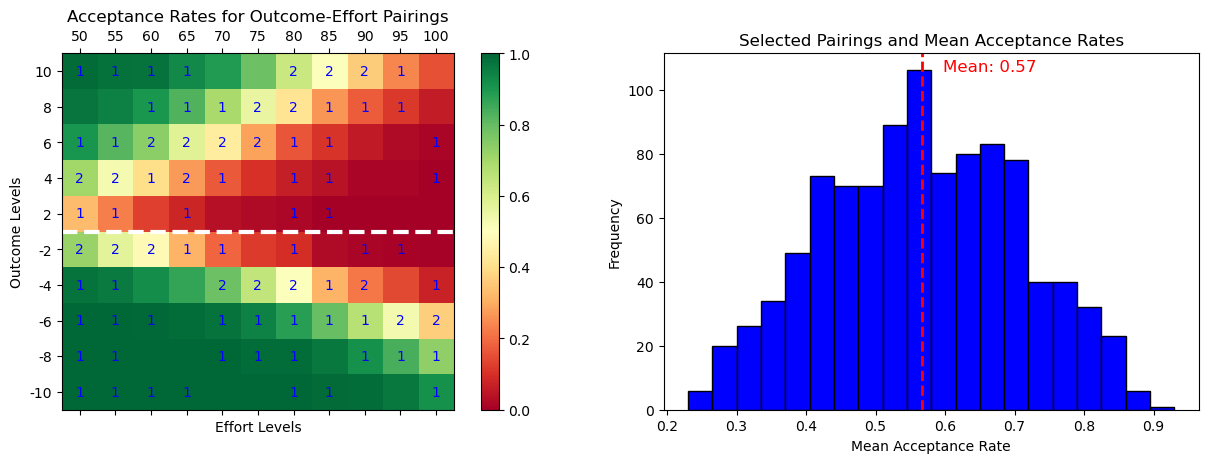

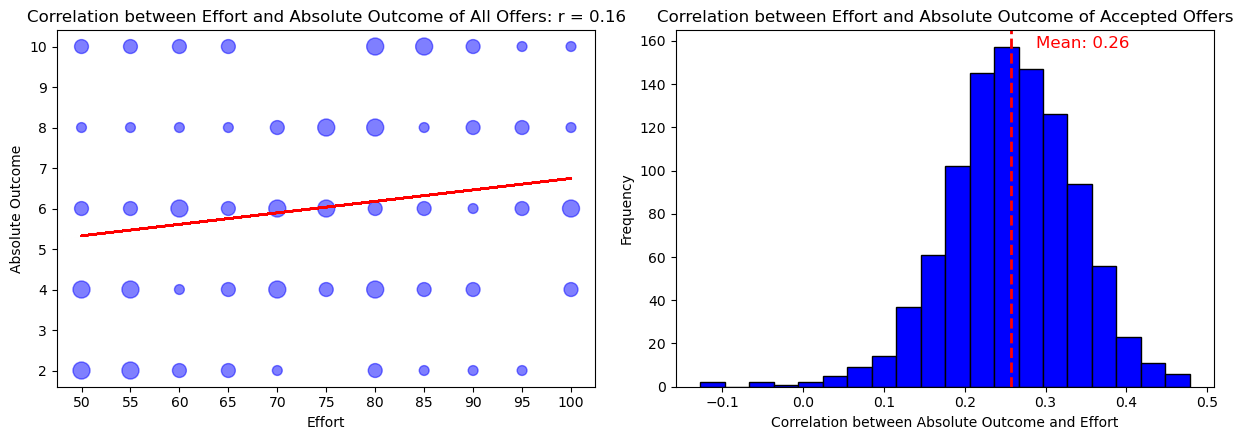

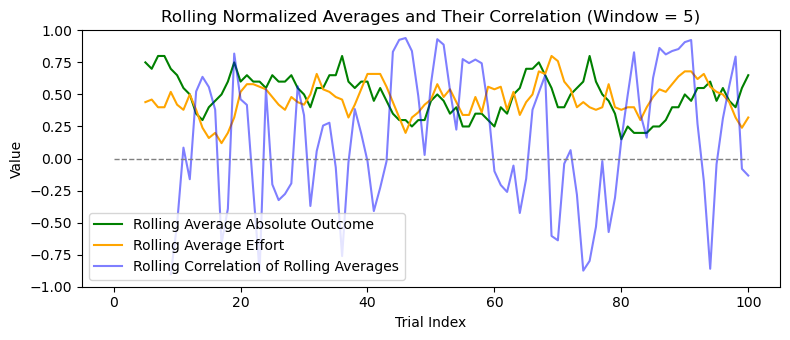

Schedule 3: Overall Correlation of Rolling Averages = 0.17
 


------------------------------------------------ Schedule 4 --------------------------------------------------


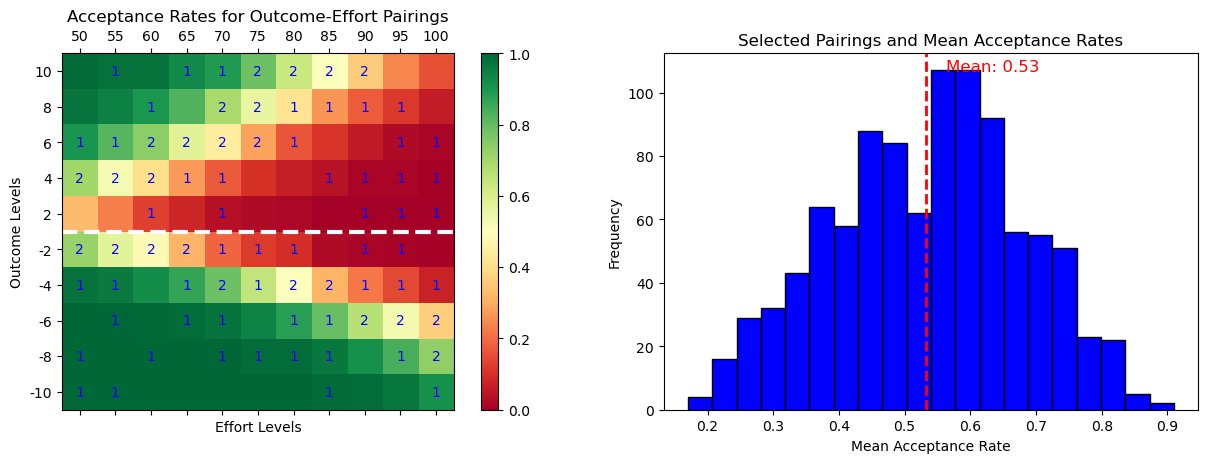

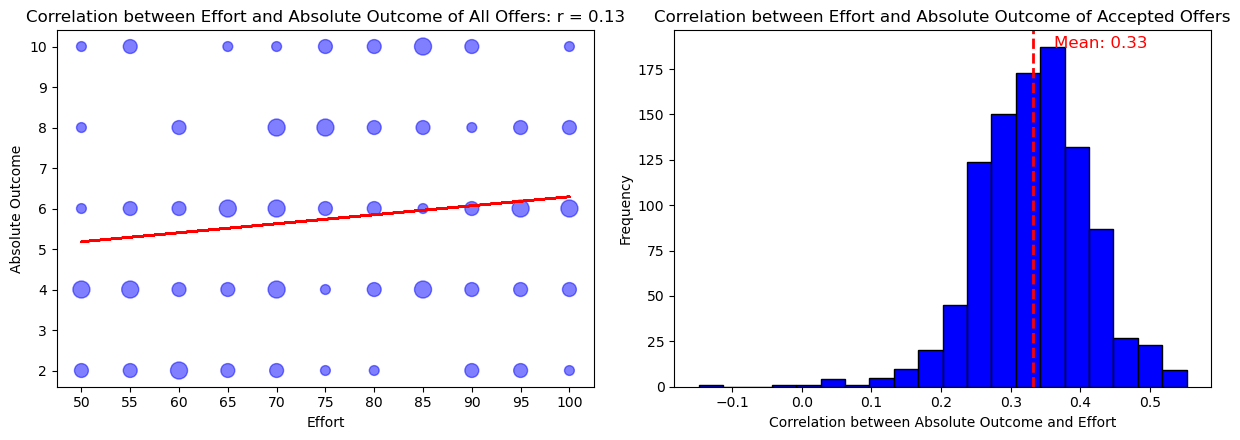

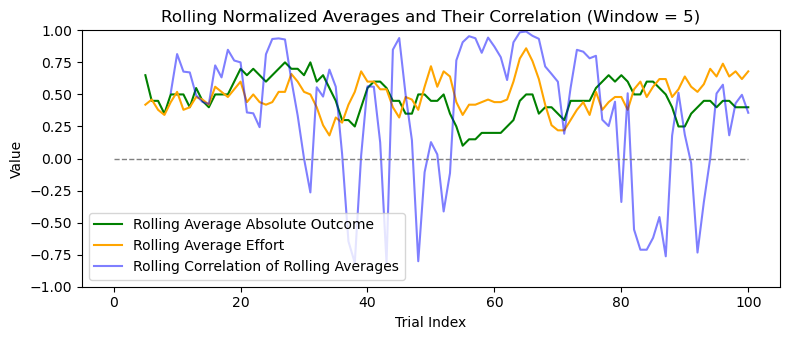

Schedule 4: Overall Correlation of Rolling Averages = 0.12
 


------------------------------------------------ Schedule 5 --------------------------------------------------


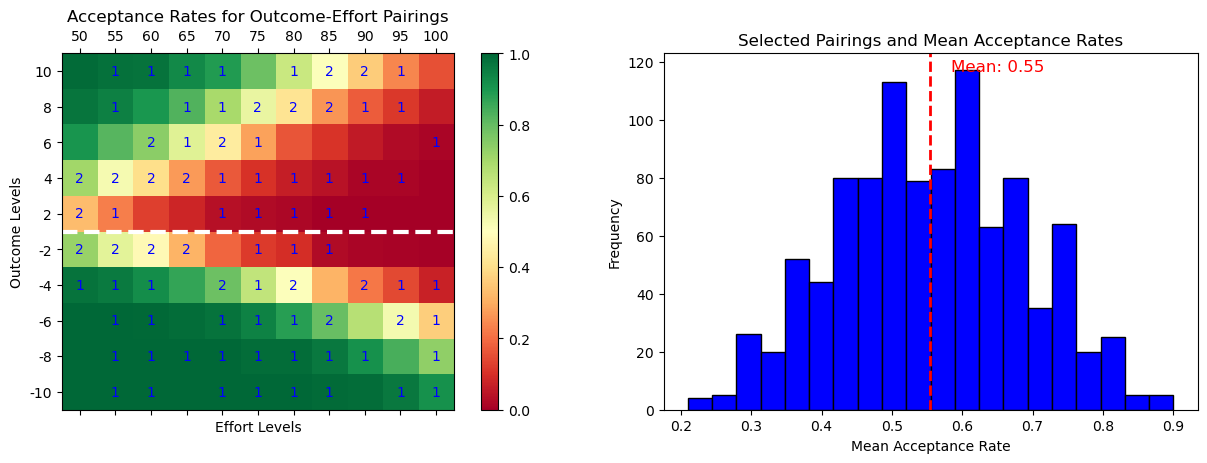

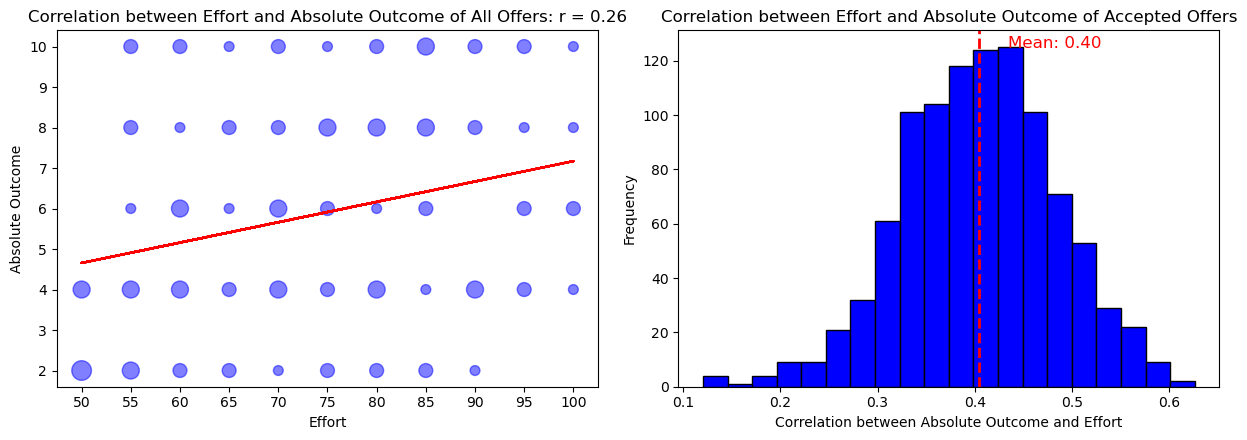

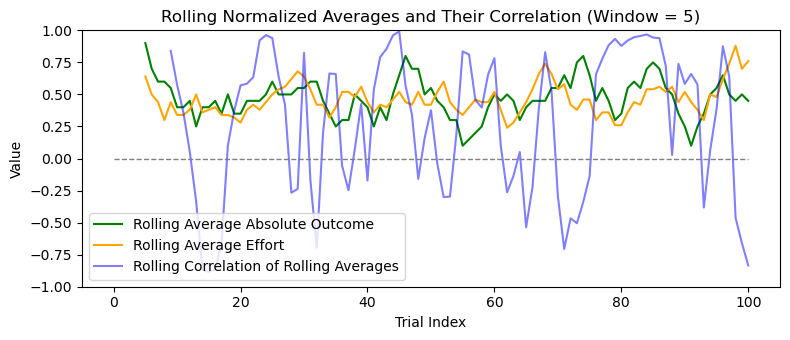

Schedule 5: Overall Correlation of Rolling Averages = 0.29


In [11]:
# Define the number of trials and structure for the experiment
num_trials = 400  # Total number of trials
num_blocks = 8  # Number of blocks, each block represents a unique condition combination
num_trials_per_block = int(num_trials / num_blocks)  # Trials per block

# Define reward and effort levels
outcome_levels_n = np.linspace(-10, 10, 11)  # Reward levels ranging from -10 to 10
outcome_levels = outcome_levels_n[outcome_levels_n != 0]  # Remove 0 from reward levels
effort_levels = np.linspace(5, 10, 11)  # Effort levels ranging from 5 to 10

# Simulate participants with different sensitivities based on literature values
num_participants = 1000  # Number of participants to simulate
# Mean and standard deviation of sensitivity parameters for the original participants
alpha_mean, alpha_std = 0.9, 0.05  # Reward sensitivity parameters
lambda_mean, lambda_std = 2.0, 0.2  # Loss aversion parameters
k_mean, k_std = 0.11, 0.02  # Effort sensitivity parameters

# Generate sensitivity parameters for each participant from normal distributions
alpha_values = np.random.normal(alpha_mean, alpha_std, num_participants)
lambda_values = np.random.normal(lambda_mean, lambda_std, num_participants)
k_values = np.random.normal(k_mean, k_std, num_participants)

# Ensure parameters are within reasonable bounds
alpha_values = np.clip(alpha_values, 0.7, 1.2)
lambda_values = np.clip(lambda_values, 1.5, 2.5)
k_values = np.clip(k_values, 0, 1)

# Function to calculate net value based on outcome, effort, and sensitivity parameters
def calculate_net_value(outcome, effort, alpha, k, lambda_):
    if outcome >= 0:
        return (outcome ** alpha) - k * (effort ** 2)  # For positive outcomes
    else:
        return abs(-lambda_ * ((-outcome) ** alpha)) - k * (effort ** 2)  # For negative outcomes

# Logistic function to convert net value to choice probabilities
decision_beta = 1  
def logistic_choice_prob(net_value, decision_beta):
    return 1 / (1 + np.exp(-decision_beta * net_value))

# Generate stimuli and simulate responses
stimuli = []  # List to store stimuli
responses = []  # List to store responses

for outcome in outcome_levels:
    for effort in effort_levels:
        # Calculate net values for all participants
        net_values = np.array([calculate_net_value(outcome, effort, alpha, k, lambda_)
                               for alpha, k, lambda_ in zip(alpha_values, k_values, lambda_values)])
        # Calculate acceptance probabilities using logistic function
        probabilities = logistic_choice_prob(net_values, decision_beta)
        # Simulate binary choices (accept/reject) based on probabilities
        choices = np.random.binomial(1, probabilities)
        # Store stimuli and responses
        stimuli.append((outcome, effort))
        responses.append(choices)

# Convert responses to numpy array and calculate acceptance rates
responses = np.array(responses)
acceptance_rates = responses.mean(axis=1)

# Reshape acceptance rates to create a matrix for outcome-effort pairings
acceptance_matrix = acceptance_rates.reshape(len(outcome_levels), len(effort_levels))

# Calculate sampling density inversely proportional to distance from 0.5 acceptance rate
distance_from_05 = np.abs(acceptance_rates - 0.5)
distance_from_05[distance_from_05 == 0] = 1e-6  # Avoid division by zero
sampling_density = 1 / (distance_from_05) 

# Create index pairs for positive and negative outcomes combined with all effort levels
positive_outcomes_idx = np.where(outcome_levels > 0)[0]
negative_outcomes_idx = np.where(outcome_levels < 0)[0]
positive_pairs = [(i, j) for i in positive_outcomes_idx for j in range(len(effort_levels))]
negative_pairs = [(i, j) for i in negative_outcomes_idx for j in range(len(effort_levels))]

# Calculate sampling probabilities for positive and negative pairs based on sampling densities
positive_sampling_density = np.array([sampling_density[i * len(effort_levels) + j] for i, j in positive_pairs])
negative_sampling_density = np.array([sampling_density[i * len(effort_levels) + j] for i, j in negative_pairs])

# Normalize sampling densities to get probabilities
positive_sampling_prob = positive_sampling_density / positive_sampling_density.sum()
negative_sampling_prob = negative_sampling_density / negative_sampling_density.sum()

# Function to calculate rolling correlation
def rolling_correlation(x, y, window):
    corrs = []
    for i in range(window, len(x) + 1):
        corr = np.corrcoef(x[i-window:i], y[i-window:i])[0, 1]
        corrs.append(corr)
    return corrs

# Function to calculate rolling average
def rolling_average(data, window):
    averages = []
    for i in range(window, len(data) + 1):
        average = np.mean(data[i-window:i])
        averages.append(average)
    return averages

window_size = 5

# Function to normalize data to range 0-1
def normalize(data):
    min_val = min(data)
    max_val = max(data)
    return [(x - min_val) / (max_val - min_val) for x in data]


# Function to generate a schedule of trials
def generate_schedule(seed):
    np.random.seed(seed)
    # Initialize lists and counters for selected pairs
    selected_positive_pairs = []
    selected_negative_pairs = []
    positive_pair_counts = {pair: 0 for pair in positive_pairs}
    negative_pair_counts = {pair: 0 for pair in negative_pairs}
    
    # Sample positive pairs
    while len(selected_positive_pairs) < num_trials_per_block:
        sampled_index = np.random.choice(len(positive_pairs), p=positive_sampling_prob)
        sampled_pair = positive_pairs[sampled_index]
        pair_acceptance_rate = acceptance_rates[sampled_pair[0] * len(effort_levels) + sampled_pair[1]]
        if positive_pair_counts[sampled_pair] < 1 or (positive_pair_counts[sampled_pair] < 2 and 0.2 <= pair_acceptance_rate <= 0.8):
            selected_positive_pairs.append(sampled_pair)
            positive_pair_counts[sampled_pair] += 1

    # Sample negative pairs
    while len(selected_negative_pairs) < num_trials_per_block:
        sampled_index = np.random.choice(len(negative_pairs), p=negative_sampling_prob)
        sampled_pair = negative_pairs[sampled_index]
        pair_acceptance_rate = acceptance_rates[sampled_pair[0] * len(effort_levels) + sampled_pair[1]]
        if negative_pair_counts[sampled_pair] < 1 or (negative_pair_counts[sampled_pair] < 2 and 0.2 <= pair_acceptance_rate <= 0.8):
            selected_negative_pairs.append(sampled_pair)
            negative_pair_counts[sampled_pair] += 1

    schedule = selected_positive_pairs + selected_negative_pairs

    # Acceptance rates for selected pairs
    pair_counts = {}
    acceptance_rates_for_histogram = []
    for pair in schedule:
        if pair in pair_counts:
            pair_counts[pair] += 1
        else:
            pair_counts[pair] = 1
        acceptance_rates_for_histogram.append(acceptance_rates[pair[0] * len(effort_levels) + pair[1]])

    # Plot next two plots side by side
    fig, ax = plt.subplots(1, 2, figsize=(13, 4.5))
    fig.subplots_adjust(wspace=8)  # Add horizontal space between the plots
    
    # Plot acceptance rate matrix
    cax = ax[0].matshow(acceptance_matrix, interpolation='nearest', cmap='RdYlGn')
    fig.colorbar(cax, ax=ax[0])
    ax[0].set_xticks(np.arange(len(effort_levels)))
    ax[0].set_yticks(np.arange(len(outcome_levels)))
    ax[0].set_xticklabels((effort_levels*10).astype(int))
    ax[0].set_yticklabels(outcome_levels.astype(int))
    ax[0].invert_yaxis()
    lowest_reward_index = np.where(outcome_levels == min(abs(outcome_levels)))[0][0]
    ax[0].axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=3)
    ax[0].set_xlabel('Effort Levels')
    ax[0].set_ylabel('Outcome Levels')
    ax[0].set_title(f'Acceptance Rates for Outcome-Effort Pairings')
    for (i, j), count in pair_counts.items():
        ax[0].text(j, i, str(count), va='center', ha='center', color='blue')

    # Calculate mean acceptance rates for each participant
    participant_mean_acceptance_rates = []
    for participant_idx in range(num_participants):
        participant_responses = []
        for (outcome_idx, effort_idx) in schedule:
            pair_idx = outcome_idx * len(effort_levels) + effort_idx
            participant_responses.append(responses[pair_idx, participant_idx])
        mean_acceptance_rate = np.mean(participant_responses)
        participant_mean_acceptance_rates.append(mean_acceptance_rate)
    
    # Plot histogram of mean acceptance rates
    ax[1].hist(participant_mean_acceptance_rates, bins=20, color='blue', edgecolor='black')
    overall_mean_acceptance_rate = np.mean(participant_mean_acceptance_rates)
    ax[1].axvline(overall_mean_acceptance_rate, color='red', linestyle='--', linewidth=2)
    label_x_position = overall_mean_acceptance_rate + 0.03  
    label_y_position = ax[1].get_ylim()[1] * 0.95
    ax[1].text(label_x_position, label_y_position, f'Mean: {overall_mean_acceptance_rate:.2f}', color='red', fontsize=12)
    ax[1].set_xlabel('Mean Acceptance Rate')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title(f'Selected Pairings and Mean Acceptance Rates')
    plt.tight_layout()
    plt.show()
    
    # Plot next two plots side by side
    fig, ax = plt.subplots(1, 2, figsize=(13, 4.5))
    fig.subplots_adjust(wspace=10)  # Add horizontal space between the plots
    
    # Correlation between absolute outcome and effort
    outcomes = [outcome_levels[pair[0]] for pair in schedule]
    efforts = [effort_levels[pair[1]] for pair in schedule]
    absolute_outcomes = np.abs(outcomes)
    correlation = np.corrcoef(absolute_outcomes, efforts)[0, 1]
    occurrences = Counter(zip(efforts, absolute_outcomes))
    unique_efforts = np.array([pair[0] for pair in occurrences.keys()])
    unique_outcomes = np.array([pair[1] for pair in occurrences.keys()])
    sizes = np.array([count for count in occurrences.values()])
    efforts = np.array(efforts)
    absolute_outcomes = np.array(absolute_outcomes)
    ax[0].scatter(unique_efforts, unique_outcomes, s=sizes*50, c='blue', alpha=0.5)
    m, b = np.polyfit(efforts, absolute_outcomes, 1)
    ax[0].plot(efforts, m * efforts + b, color='red')
    xticks = np.unique(efforts) * 10
    ax[0].set_xticks(ticks=np.unique(efforts))
    ax[0].set_xticklabels([int(x) for x in xticks])
    ax[0].set_xlabel('Effort')
    ax[0].set_ylabel('Absolute Outcome')
    ax[0].set_title(f'Correlation between Effort and Absolute Outcome of All Offers: r = {correlation:.2f}')
    
    # Correlation for each participant based on accepted pairs
    correlations = []
    for participant_idx in range(num_participants):
        participant_accepted_outcomes = []
        participant_accepted_efforts = []
        for (outcome_idx, effort_idx) in schedule:
            pair_idx = outcome_idx * len(effort_levels) + effort_idx
            if responses[pair_idx, participant_idx] == 1:  # If the participant accepted the offer
                participant_accepted_outcomes.append(outcome_levels[outcome_idx])
                participant_accepted_efforts.append(effort_levels[effort_idx])
        if len(participant_accepted_outcomes) > 1:
            absolute_outcomes = np.abs(participant_accepted_outcomes)
            correlation = np.corrcoef(absolute_outcomes, participant_accepted_efforts)[0, 1]
        else:
            correlation = np.nan  # If less than 2 offers were accepted, correlation is undefined
        correlations.append(correlation)
    correlations = [corr for corr in correlations if not np.isnan(corr)]
    ax[1].hist(correlations, bins=20, color='blue', edgecolor='black')
    mean_correlation = np.mean(correlations)
    ax[1].axvline(mean_correlation, color='red', linestyle='--', linewidth=2)
    label_x_position = mean_correlation + 0.03  
    label_y_position = ax[1].get_ylim()[1] * 0.95
    ax[1].text(label_x_position, label_y_position, f'Mean: {mean_correlation:.2f}', color='red', fontsize=12)
    ax[1].set_xlabel('Correlation between Absolute Outcome and Effort')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title(f'Correlation between Effort and Absolute Outcome of Accepted Offers')
    plt.tight_layout()
    plt.show()

    # Rolling averages of efforts and outcoms
    outcomes = [outcome_levels[pair[0]] for pair in schedule]
    efforts = [effort_levels[pair[1]] for pair in schedule]
    absolute_outcomes = np.abs(outcomes)
    normalized_efforts = normalize(efforts)
    normalized_absolute_outcomes = normalize(absolute_outcomes)
    rolling_avg_abs_outcomes = rolling_average(normalized_absolute_outcomes, window_size)
    rolling_avg_efforts = rolling_average(normalized_efforts, window_size)
    indices = range(window_size, len(schedule) + 1)
    # Convert rolling averages to pandas Series for rolling correlation calculation
    series_rolling_avg_abs_outcomes = pd.Series(rolling_avg_abs_outcomes)
    series_rolling_avg_efforts = pd.Series(rolling_avg_efforts)
    # Calculate rolling correlation of rolling averages
    rolling_corr_of_averages = series_rolling_avg_abs_outcomes.rolling(window=window_size).corr(series_rolling_avg_efforts)
    plt.figure(figsize=(8, 3.5))
    plt.plot(indices, rolling_avg_abs_outcomes, label='Rolling Average Absolute Outcome', color='green')
    plt.plot(indices, rolling_avg_efforts, label='Rolling Average Effort', color='orange')
    plt.plot(indices, rolling_corr_of_averages, label='Rolling Correlation of Rolling Averages', color='blue', alpha=0.5)
    plt.ylim(-1, 1)
    plt.xlabel('Trial Index')
    plt.ylabel('Value')
    plt.hlines(0, 0, len(schedule), colors='gray', linestyles='dashed', linewidth=1)
    plt.title(f'Rolling Normalized Averages and Their Correlation (Window = {window_size})')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Calculate overall correlation of rolling averages
    overall_corr_of_averages = np.corrcoef(rolling_avg_abs_outcomes, rolling_avg_efforts)[0, 1]
    print(f"Schedule {seed + 1}: Overall Correlation of Rolling Averages = {overall_corr_of_averages:.2f}")


    return schedule


# Generate multiple schedules
num_schedules = 5
schedules = []

# Generate schedules by calling generate_schedule with different seeds
for seed in range(num_schedules):
    print(f"\033[1m \n\n\n------------------------------------------------ Schedule {seed + 1} --------------------------------------------------\033[0m")
    schedule = generate_schedule(seed)
    schedules.append(schedule)

In [12]:
# # This is a bit weird because the roling correlation doesnt quite correspond to the rolling averages

# for seed, schedule in enumerate(schedules):
#     outcomes = [outcome_levels[pair[0]] for pair in schedule]
#     efforts = [effort_levels[pair[1]] for pair in schedule]
#     absolute_outcomes = np.abs(outcomes)
    
#     normalized_efforts = normalize(efforts)
#     normalized_absolute_outcomes = normalize(absolute_outcomes)
    
#     rolling_avg_abs_outcomes = rolling_average(normalized_absolute_outcomes, window_size)
#     rolling_avg_efforts = rolling_average(normalized_efforts, window_size)
#     rolling_corrs = rolling_correlation(normalized_absolute_outcomes, normalized_efforts, window_size)
    
#     indices = range(window_size, len(schedule) + 1)
    
#     plt.figure(figsize=(8, 3.5))
#     plt.plot(indices, rolling_corrs, label='Rolling Correlation', color='blue', alpha=0.5)
#     plt.plot(indices, rolling_avg_abs_outcomes, label='Rolling Average Absolute Outcome', color='green')
#     plt.plot(indices, rolling_avg_efforts, label='Rolling Average Effort', color='orange')
    
#     plt.ylim(-1, 1)
#     plt.xlabel('Trial Index')
#     plt.ylabel('Value')
#     plt.hlines(0, 0, len(schedule), colors='gray', linestyles='dashed', linewidth=1)
#     plt.title(f'Schedule {seed + 1}: Rolling Correlation and Normalized Averages (Window = {window_size})')
#     plt.legend()
    
#     plt.tight_layout()
#     plt.show()

In [13]:
# # This is a bit weird because participants have different numnbers of accepted trials

# # Function to calculate rolling correlation
# def rolling_correlation(x, y, window):
#     corrs = []
#     for i in range(len(x) - window + 1):
#         corr = np.corrcoef(x[i:i+window], y[i:i+window])[0, 1]
#         corrs.append(corr)
#     return corrs

# # Calculate rolling correlations for each schedule considering only accepted offers
# window_size = 5

# for seed, schedule in enumerate(schedules):
#     all_rolling_corrs = []
#     for participant_idx in range(num_participants):
#         accepted_outcomes = []
#         accepted_efforts = []
#         for (outcome_idx, effort_idx) in schedule:
#             pair_idx = outcome_idx * len(effort_levels) + effort_idx
#             if responses[pair_idx, participant_idx] == 1:  # If the participant accepted the offer
#                 accepted_outcomes.append(outcome_levels[outcome_idx])
#                 accepted_efforts.append(effort_levels[effort_idx])
#         if len(accepted_outcomes) >= window_size:
#             absolute_outcomes = np.abs(accepted_outcomes)
#             rolling_corr = rolling_correlation(absolute_outcomes, accepted_efforts, window_size)
#             all_rolling_corrs.append(rolling_corr)
    
#     # Determine the maximum length of rolling correlations
#     max_length = max(len(corr) for corr in all_rolling_corrs)
    
#     # Pad shorter sequences with NaN -- i.e. participants who have fewer accepted offers
#     padded_rolling_corrs = [np.pad(corr, (0, max_length - len(corr)), constant_values=np.nan) for corr in all_rolling_corrs]
    
#     # Calculate average rolling correlation across all participants
#     avg_rolling_corrs = np.nanmean(np.array(padded_rolling_corrs), axis=0)
    
#     plt.figure(figsize=(6, 3))
#     plt.plot(avg_rolling_corrs, label=f'Schedule {seed + 1}')
#     plt.xlabel('Trial Index')
#     plt.ylabel('Average Rolling Correlation')
#     plt.title(f'Average Rolling Correlation between Absolute Outcomes and Efforts for Accepted Offers (Window = {window_size})')
#     plt.legend()
#     plt.show()

### Select and save a trial schedule

In [29]:
# Function to get the schedule table
def get_schedule_table(schedule_number):
    seed = schedule_number - 1
    if seed < 0 or seed >= len(schedules):
        raise ValueError("Invalid schedule number")
    schedule = schedules[seed]
    
    # Create table
    trials = []
    for trial_number, (outcome_idx, effort_idx) in enumerate(schedule, start=1):
        outcome = outcome_levels[outcome_idx]
        effort = effort_levels[effort_idx]
        action_type = "approach" if outcome > 0 else "avoid"
        trials.append((trial_number, outcome, effort, action_type))
    
    df = pd.DataFrame(trials, columns=["trial_number", "outcome", "effort", "action_type"])
    return df

# Select schedule
schedule_number = 5
schedule_table = get_schedule_table(schedule_number)
print(schedule_table)

# Save schedule to a CSV file
csv_filename = "experiment_code/trial_schedule.csv"
schedule_table.to_csv(csv_filename, index=False)
print(f"Schedule table saved to {csv_filename}")

    trial_number  outcome  effort action_type
0              1     10.0     8.5    approach
1              2     10.0     8.5    approach
2              3     10.0     9.0    approach
3              4      6.0     6.0    approach
4              5     10.0     9.0    approach
..           ...      ...     ...         ...
95            96     -6.0    10.0       avoid
96            97     -4.0     9.0       avoid
97            98     -4.0     9.5       avoid
98            99    -10.0     5.5       avoid
99           100     -4.0    10.0       avoid

[100 rows x 4 columns]
Schedule table saved to experiment_code/trial_schedule.csv


### Test robustness of trial schedules

In [15]:
# Function to calculate acceptance rates for new participants based on the generated schedule
def calculate_new_participants_acceptance_rates(schedule, alpha_values, lambda_values, k_values):
    participant_mean_acceptance_rates = []
    for participant_idx in range(num_participants):
        participant_responses = []
        for (outcome_idx, effort_idx) in schedule:
            pair_idx = outcome_idx * len(effort_levels) + effort_idx
            outcome, effort = stimuli[pair_idx]
            net_value = calculate_net_value(outcome, effort, alpha_values[participant_idx], k_values[participant_idx], lambda_values[participant_idx])
            acceptance_probability = logistic_choice_prob(net_value, decision_beta)
            participant_responses.append(acceptance_probability)
        mean_acceptance_rate = np.mean(participant_responses)
        participant_mean_acceptance_rates.append(mean_acceptance_rate)
    return participant_mean_acceptance_rates

##### Shifting by absolute numbers

In [16]:
# Function to perform sensitivity analysis
def sensitivity_analysis(param_name, param_mean, param_std, param_absolute_shifts):
    results = []
    for i, schedule in enumerate(schedules):
        upper_threshold = None
        lower_threshold = None
        for shift in param_absolute_shifts:
            shift_positive = shift
            shift_negative = -shift

            alpha_values_shifted_pos = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            alpha_values_shifted_neg = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            lambda_values_shifted_pos = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            lambda_values_shifted_neg = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            k_values_shifted_pos = k_values if param_name != 'k' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            k_values_shifted_neg = k_values if param_name != 'k' else np.random.normal(param_mean + shift_negative, param_std, num_participants)

            participant_mean_acceptance_rates_pos = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_pos, lambda_values_shifted_pos, k_values_shifted_pos)
            mean_acceptance_rate_pos = np.mean(participant_mean_acceptance_rates_pos)
            
            participant_mean_acceptance_rates_neg = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_neg, lambda_values_shifted_neg, k_values_shifted_neg)
            mean_acceptance_rate_neg = np.mean(participant_mean_acceptance_rates_neg)

            if upper_threshold is None and mean_acceptance_rate_pos > 0.6 or mean_acceptance_rate_pos < 0.4:
                upper_threshold = shift
            if lower_threshold is None and mean_acceptance_rate_neg < 0.4 or mean_acceptance_rate_neg > 0.6:
                lower_threshold = shift
            
            if upper_threshold is not None and lower_threshold is not None:
                break
        
        results.append((i + 1, upper_threshold, lower_threshold))

    # Printing results in specified format
    for schedule_num, upper, lower in results:
        print(f"Schedule {schedule_num}\nupper threshold: + {upper:.2f}\nlower threshold: - {lower:.2f}\n")

# Define ranges for parameter shifts as absolute values
param_absolute_shifts = np.arange(0, 2, 0.01)  # steps of 0.01

# Perform sensitivity analysis for alpha
print("Sensitivity analysis for alpha:")
sensitivity_analysis('alpha', alpha_mean, alpha_std, param_absolute_shifts)

# Perform sensitivity analysis for lambda
print("\nSensitivity analysis for lambda:")
sensitivity_analysis('lambda', lambda_mean, lambda_std, param_absolute_shifts)

# Perform sensitivity analysis for k
print("\nSensitivity analysis for k:")
sensitivity_analysis('k', k_mean, k_std, param_absolute_shifts)


Sensitivity analysis for alpha:
Schedule 1
upper threshold: + 0.07
lower threshold: - 0.13

Schedule 2
upper threshold: + 0.09
lower threshold: - 0.13

Schedule 3
upper threshold: + 0.04
lower threshold: - 0.16

Schedule 4
upper threshold: + 0.07
lower threshold: - 0.12

Schedule 5
upper threshold: + 0.06
lower threshold: - 0.16


Sensitivity analysis for lambda:
Schedule 1
upper threshold: + 0.49
lower threshold: - 0.75

Schedule 2
upper threshold: + 0.74
lower threshold: - 0.66

Schedule 3
upper threshold: + 0.27
lower threshold: - 0.90

Schedule 4
upper threshold: + 0.51
lower threshold: - 0.71

Schedule 5
upper threshold: + 0.46
lower threshold: - 0.83


Sensitivity analysis for k:
Schedule 1
upper threshold: + 0.03
lower threshold: - 0.03

Schedule 2
upper threshold: + 0.03
lower threshold: - 0.03

Schedule 3
upper threshold: + 0.04
lower threshold: - 0.04

Schedule 4
upper threshold: + 0.03
lower threshold: - 0.03

Schedule 5
upper threshold: + 0.04
lower threshold: - 0.04



##### Shifting parameters by % of mean

In [17]:
# Function to perform sensitivity analysis
def sensitivity_analysis(param_name, param_mean, param_std, param_percentage_range):
    results = []
    for i, schedule in enumerate(schedules):
        upper_threshold = None
        lower_threshold = None
        for percentage in param_percentage_range:
            shift_positive = param_mean * (percentage / 100)
            shift_negative = -param_mean * (percentage / 100)

            alpha_values_shifted_pos = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            alpha_values_shifted_neg = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            lambda_values_shifted_pos = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            lambda_values_shifted_neg = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            k_values_shifted_pos = k_values if param_name != 'k' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            k_values_shifted_neg = k_values if param_name != 'k' else np.random.normal(param_mean + shift_negative, param_std, num_participants)

            participant_mean_acceptance_rates_pos = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_pos, lambda_values_shifted_pos, k_values_shifted_pos)
            mean_acceptance_rate_pos = np.mean(participant_mean_acceptance_rates_pos)
            
            participant_mean_acceptance_rates_neg = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_neg, lambda_values_shifted_neg, k_values_shifted_neg)
            mean_acceptance_rate_neg = np.mean(participant_mean_acceptance_rates_neg)

            if upper_threshold is None and mean_acceptance_rate_pos > 0.6 or mean_acceptance_rate_pos < 0.4:
                upper_threshold = percentage
            if lower_threshold is None and mean_acceptance_rate_neg < 0.4 or mean_acceptance_rate_neg > 0.6:
                lower_threshold = percentage
            
            if upper_threshold is not None and lower_threshold is not None:
                break
        
        results.append((i + 1, upper_threshold, lower_threshold))

    # Printing results in specified format
    for schedule_num, upper, lower in results:
        print(f"Schedule {schedule_num}\nupper threshold: + {upper}%\nlower threshold: - {lower}%\n")

# Define ranges for parameter shifts as percentages
param_percentage_range = np.arange(0, 100, 1)  # steps of 1%

# Perform sensitivity analysis for alpha
print("Sensitivity analysis for alpha:")
sensitivity_analysis('alpha', alpha_mean, alpha_std, param_percentage_range)

# Perform sensitivity analysis for lambda
print("\nSensitivity analysis for lambda:")
sensitivity_analysis('lambda', lambda_mean, lambda_std, param_percentage_range)

# Perform sensitivity analysis for k
print("\nSensitivity analysis for k:")
sensitivity_analysis('k', k_mean, k_std, param_percentage_range)


Sensitivity analysis for alpha:
Schedule 1
upper threshold: + 7%
lower threshold: - 15%

Schedule 2
upper threshold: + 10%
lower threshold: - 14%

Schedule 3
upper threshold: + 5%
lower threshold: - 18%

Schedule 4
upper threshold: + 8%
lower threshold: - 13%

Schedule 5
upper threshold: + 6%
lower threshold: - 17%


Sensitivity analysis for lambda:
Schedule 1
upper threshold: + 24%
lower threshold: - 38%

Schedule 2
upper threshold: + 37%
lower threshold: - 34%

Schedule 3
upper threshold: + 14%
lower threshold: - 45%

Schedule 4
upper threshold: + 26%
lower threshold: - 36%

Schedule 5
upper threshold: + 23%
lower threshold: - 42%


Sensitivity analysis for k:
Schedule 1
upper threshold: + 23%
lower threshold: - 23%

Schedule 2
upper threshold: + 22%
lower threshold: - 22%

Schedule 3
upper threshold: + 29%
lower threshold: - 29%

Schedule 4
upper threshold: + 21%
lower threshold: - 21%

Schedule 5
upper threshold: + 28%
lower threshold: - 28%



##### Shifting parameters by std

In [18]:
# Function to perform sensitivity analysis
def sensitivity_analysis(param_name, param_mean, param_std, param_std_range):
    results = []
    for i, schedule in enumerate(schedules):
        upper_threshold = None
        lower_threshold = None
        for num_std in param_std_range:
            shift_positive = param_std * num_std
            shift_negative = -param_std * num_std

            alpha_values_shifted_pos = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            alpha_values_shifted_neg = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            lambda_values_shifted_pos = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            lambda_values_shifted_neg = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            k_values_shifted_pos = k_values if param_name != 'k' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            k_values_shifted_neg = k_values if param_name != 'k' else np.random.normal(param_mean + shift_negative, param_std, num_participants)

            participant_mean_acceptance_rates_pos = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_pos, lambda_values_shifted_pos, k_values_shifted_pos)
            mean_acceptance_rate_pos = np.mean(participant_mean_acceptance_rates_pos)
            
            participant_mean_acceptance_rates_neg = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_neg, lambda_values_shifted_neg, k_values_shifted_neg)
            mean_acceptance_rate_neg = np.mean(participant_mean_acceptance_rates_neg)

            if upper_threshold is None and mean_acceptance_rate_pos > 0.6 or mean_acceptance_rate_pos < 0.4:
                upper_threshold = num_std
            if lower_threshold is None and mean_acceptance_rate_neg < 0.4 or mean_acceptance_rate_neg > 0.6:
                lower_threshold = num_std
            
            if upper_threshold is not None and lower_threshold is not None:
                break
        
        results.append((i + 1, upper_threshold, lower_threshold))

    # Printing results in specified format
    for schedule_num, upper, lower in results:
        print(f"Schedule {schedule_num}\nupper threshold: + {upper:.2f} std\nlower threshold: - {lower:.2f} std\n")

# Define ranges for parameter shifts in terms of standard deviations
param_std_range = np.arange(0, 5, 0.1)  # steps of 0.1 standard deviations

# Perform sensitivity analysis for alpha
print("Sensitivity analysis for alpha:")
sensitivity_analysis('alpha', alpha_mean, alpha_std, param_std_range)

# Perform sensitivity analysis for lambda
print("\nSensitivity analysis for lambda:")
sensitivity_analysis('lambda', lambda_mean, lambda_std, param_std_range)

# Perform sensitivity analysis for k
print("\nSensitivity analysis for k:")
sensitivity_analysis('k', k_mean, k_std, param_std_range)


Sensitivity analysis for alpha:
Schedule 1
upper threshold: + 1.30 std
lower threshold: - 2.60 std

Schedule 2
upper threshold: + 1.90 std
lower threshold: - 2.60 std

Schedule 3
upper threshold: + 0.80 std
lower threshold: - 3.10 std

Schedule 4
upper threshold: + 1.40 std
lower threshold: - 2.20 std

Schedule 5
upper threshold: + 1.20 std
lower threshold: - 3.10 std


Sensitivity analysis for lambda:
Schedule 1
upper threshold: + 2.40 std
lower threshold: - 3.80 std

Schedule 2
upper threshold: + 3.70 std
lower threshold: - 3.30 std

Schedule 3
upper threshold: + 1.40 std
lower threshold: - 4.60 std

Schedule 4
upper threshold: + 2.60 std
lower threshold: - 3.60 std

Schedule 5
upper threshold: + 2.30 std
lower threshold: - 4.20 std


Sensitivity analysis for k:
Schedule 1
upper threshold: + 1.30 std
lower threshold: - 1.30 std

Schedule 2
upper threshold: + 1.20 std
lower threshold: - 1.20 std

Schedule 3
upper threshold: + 1.60 std
lower threshold: - 1.60 std

Schedule 4
upper thre

##### Visualising percentage change in parameter effect on acceptance rates

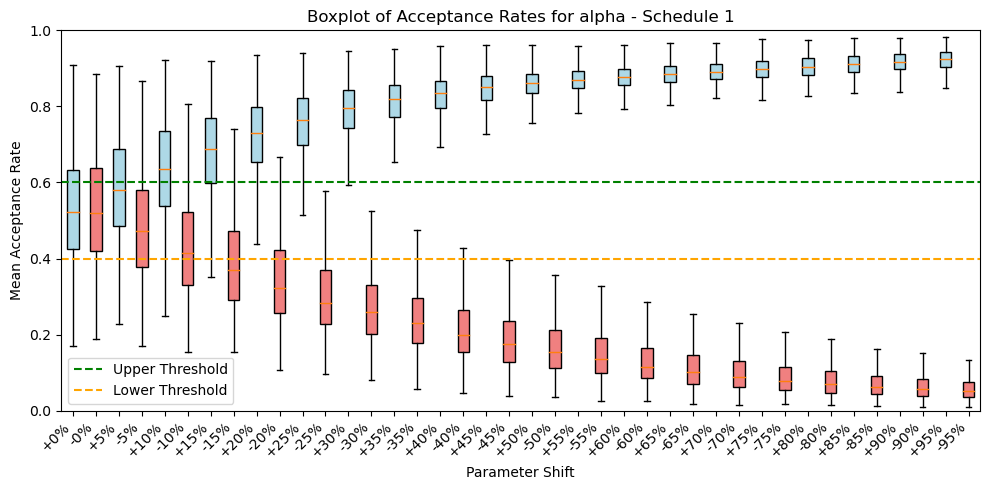

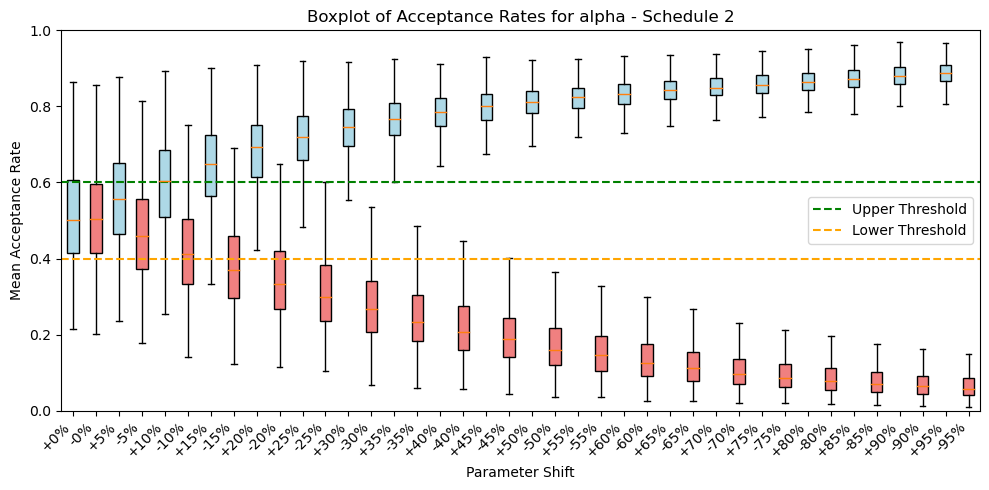

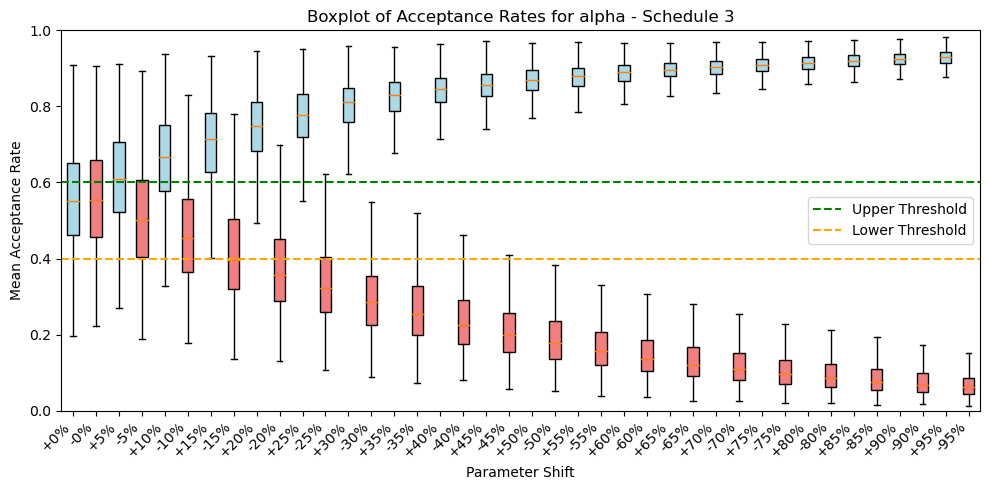

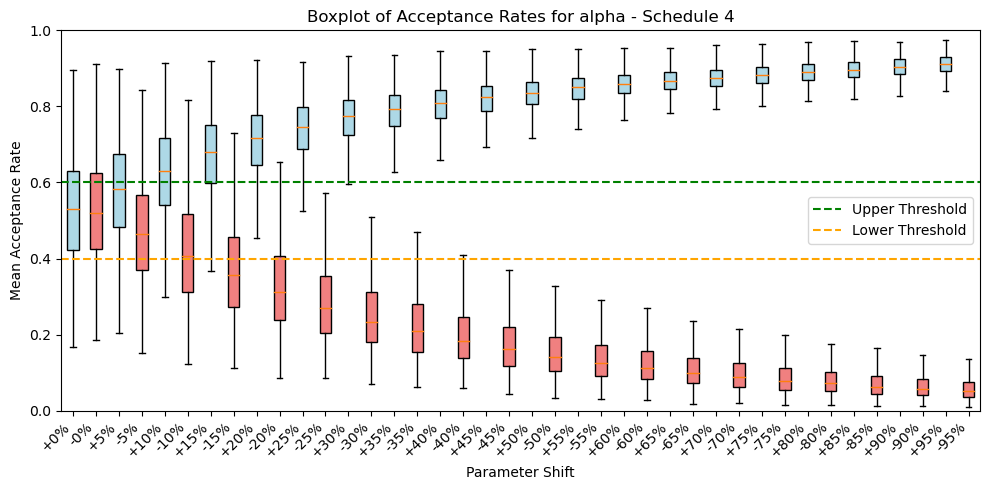

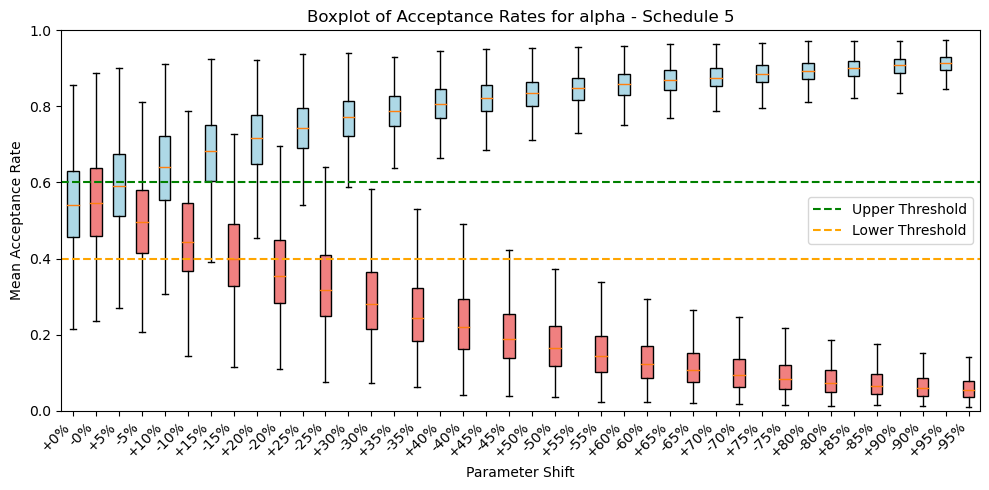

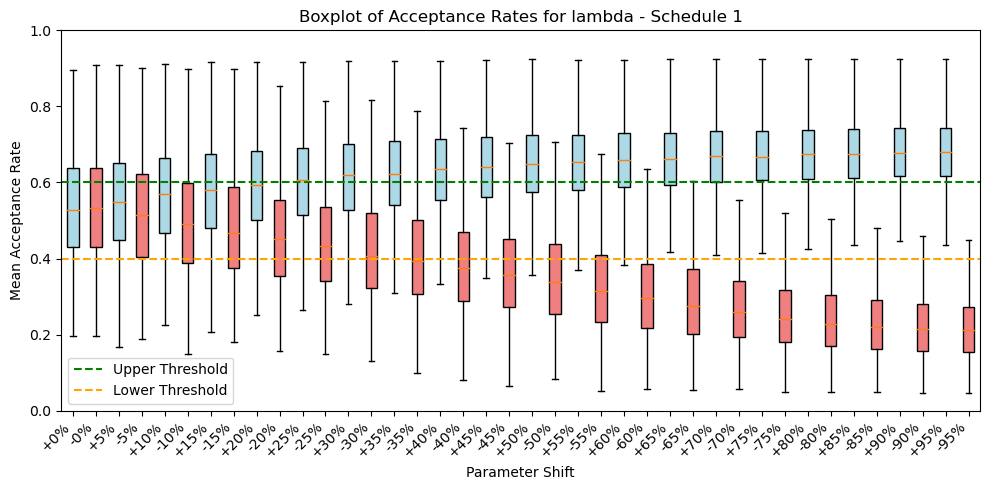

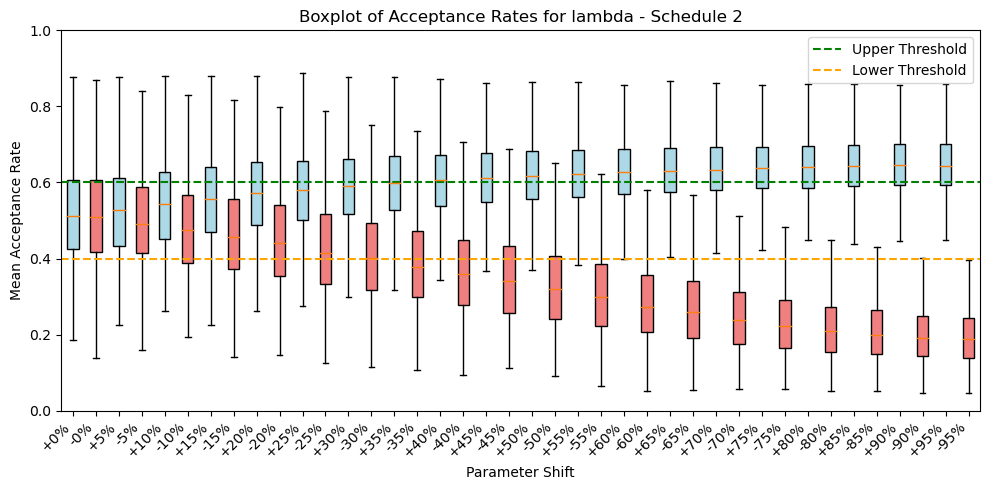

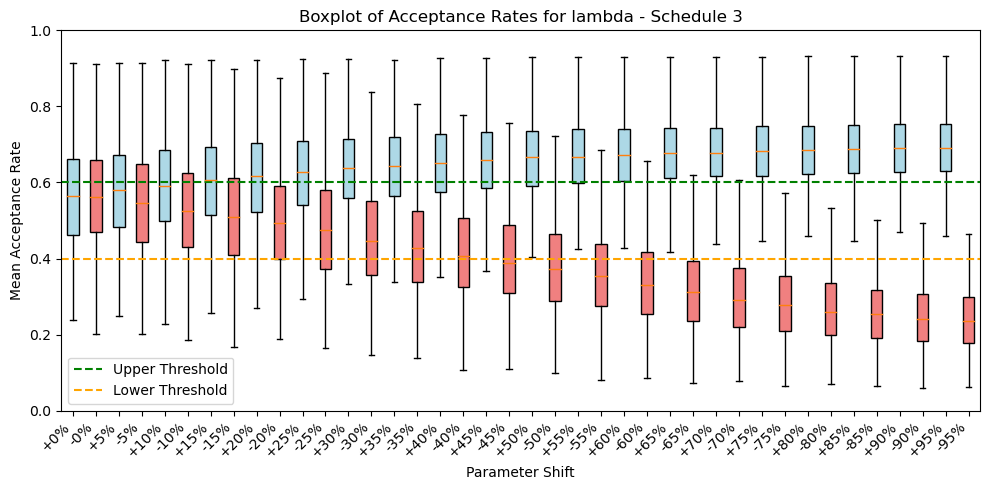

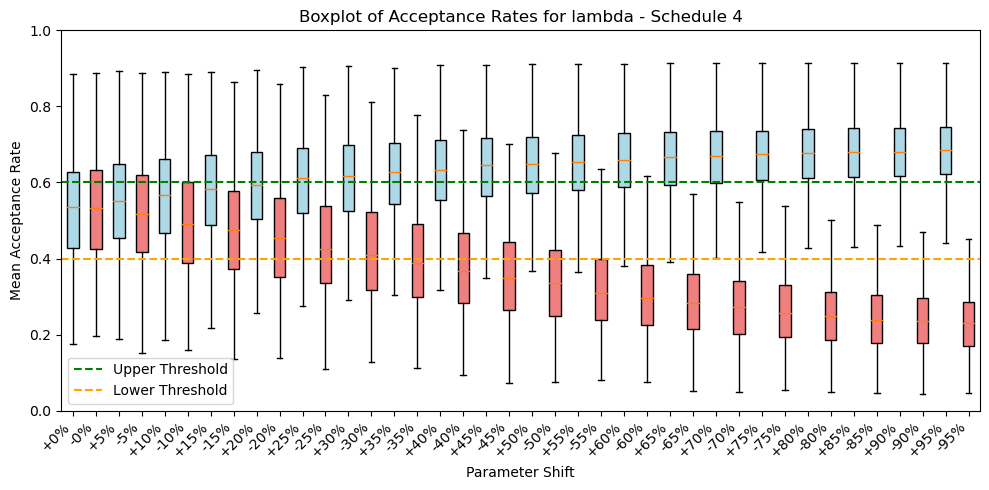

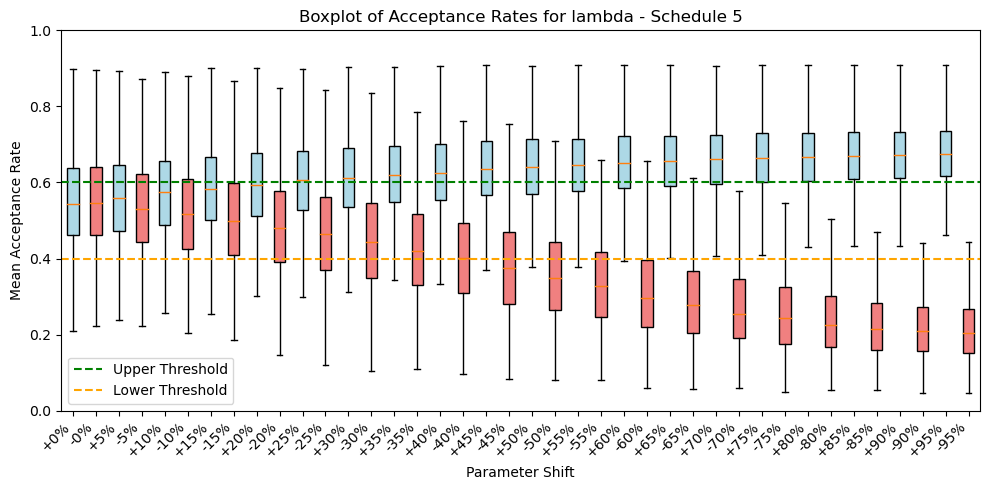

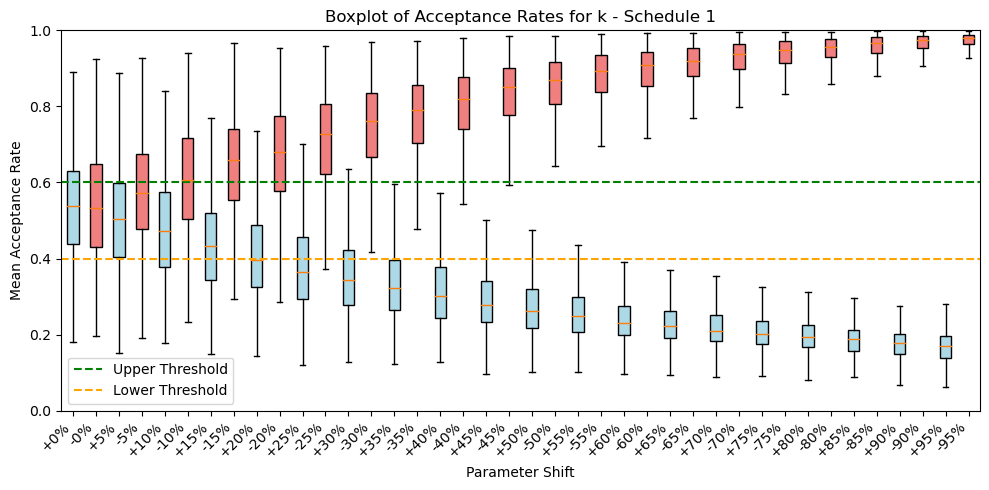

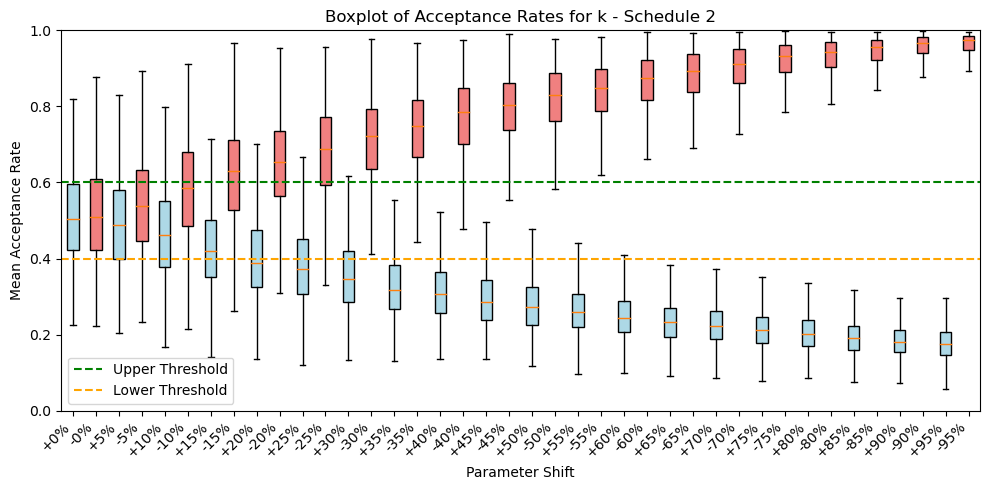

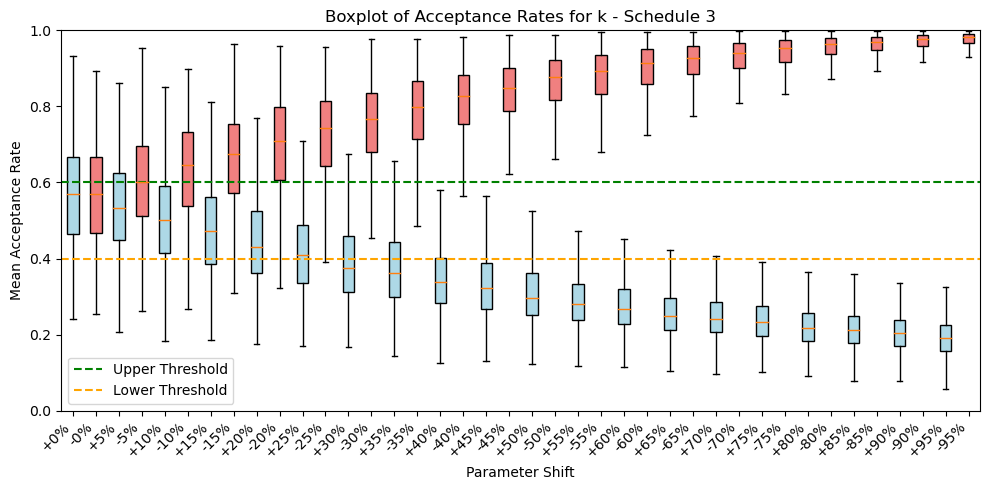

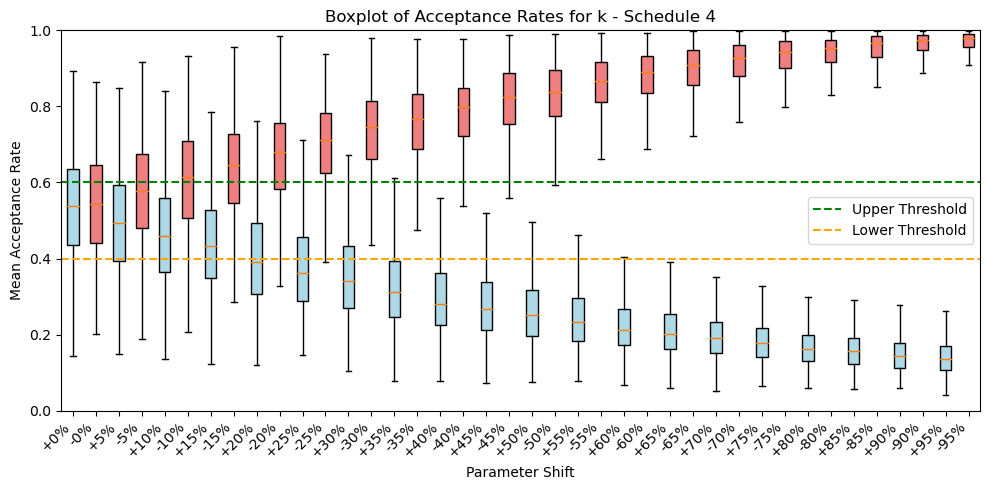

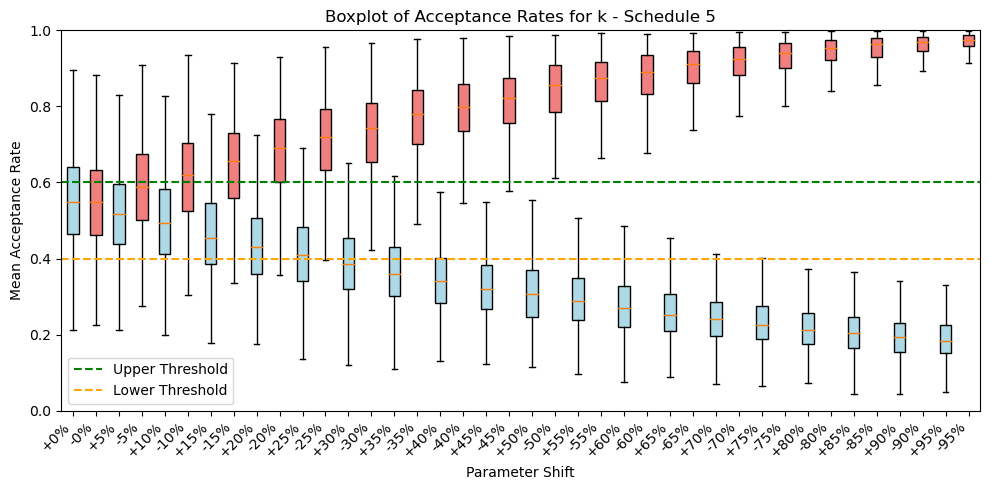

In [19]:
def plot_boxplot(param_name, param_mean, param_std, param_percentage_range, step=5):
    for i, schedule in enumerate(schedules):
        all_acceptance_rates = []
        labels = []
        for percentage in param_percentage_range[::step]:  # Reduced number of labels by step
            shift_positive = param_mean * (percentage / 100)
            shift_negative = -param_mean * (percentage / 100)

            alpha_values_shifted_pos = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            alpha_values_shifted_neg = alpha_values if param_name != 'alpha' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            lambda_values_shifted_pos = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            lambda_values_shifted_neg = lambda_values if param_name != 'lambda' else np.random.normal(param_mean + shift_negative, param_std, num_participants)
            
            k_values_shifted_pos = k_values if param_name != 'k' else np.random.normal(param_mean + shift_positive, param_std, num_participants)
            k_values_shifted_neg = k_values if param_name != 'k' else np.random.normal(param_mean + shift_negative, param_std, num_participants)

            participant_mean_acceptance_rates_pos = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_pos, lambda_values_shifted_pos, k_values_shifted_pos)
            all_acceptance_rates.append(participant_mean_acceptance_rates_pos)
            labels.append(f'+{percentage}%')
            
            participant_mean_acceptance_rates_neg = calculate_new_participants_acceptance_rates(schedule, alpha_values_shifted_neg, lambda_values_shifted_neg, k_values_shifted_neg)
            all_acceptance_rates.append(participant_mean_acceptance_rates_neg)
            labels.append(f'-{percentage}%')

        plt.figure(figsize=(10, 5))
        box = plt.boxplot(all_acceptance_rates, labels=labels, patch_artist=True, showfliers=False)

        # Color positive and negative shifts differently
        colors = ['lightblue' if '+' in label else 'lightcoral' for label in labels]
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        plt.axhline(y=0.6, color='green', linestyle='--', label='Upper Threshold')
        plt.axhline(y=0.4, color='orange', linestyle='--', label='Lower Threshold')
        plt.ylim(0, 1)
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('Parameter Shift')
        plt.ylabel('Mean Acceptance Rate')
        plt.title(f'Boxplot of Acceptance Rates for {param_name} - Schedule {i+1}')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Define ranges for parameter shifts as percentages
param_percentage_range = np.arange(0, 100, 1)  # steps of 1%

# Perform the boxplots for each parameter
plot_boxplot('alpha', alpha_mean, alpha_std, param_percentage_range)
plot_boxplot('lambda', lambda_mean, lambda_std, param_percentage_range)
plot_boxplot('k', k_mean, k_std, param_percentage_range)
